In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from time import sleep
from tqdm import tqdm
import warnings
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020','2021','2022']
actual_years = ['2018','2019','2020','2021','2022','2023']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

# read feature dataset
relative_path_features = os.path.join('..', 'data', 'cm_features.parquet')
path_features = os.path.join(current_dir, relative_path_features)
feature_data = pd.read_parquet(path_features, engine='pyarrow')

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    feature_data_toOct = feature_data[feature_data['month_id'] <= 454 + (i * 12)]
    feature_data_toOct.set_index(['month_id', 'country_id'], inplace=True)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':feature_data_toOct})


country_list = sorted(features_df_list[-1]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all years
country_feature_group_list = []
country_actual_group_list = []

# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

# last dataset contains all other datasets (because of concat) 
all_features = features_df_list[-1]['data'].columns

relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data_views = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data_views.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        # check if actuals exist for the country
        if check_Actuals(country_id, 0):
            # check if the last feature month is 3 months before the first actuals month
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

# concat all actual month ged_sb for each country
actuals_df_concat = pd.DataFrame()

for i in range(1,len(actuals_df_list)):
    if i == 1:
        actuals_df_concat = pd.concat([actuals_df_list[i-1]['data'], actuals_df_list[i]['data']])
    else:
        actuals_df_concat = pd.concat([actuals_df_concat, actuals_df_list[i]['data']])

actuals_df_concat_group = actuals_df_concat.groupby('country_id')


## Result plots

In [2]:
zero_fatalities_country_list = []
countries_with_low_conflict_list = []
countries_with_middle_conflict_list = []
countries_with_high_conflict_list = []

features_df_concat = features_df_list[3]['data']
features_df_concat_group = features_df_concat.groupby('country_id')

for country_id in country_list:
    feature_data_oct17 = features_df_concat_group.get_group(country_id)

    # Berechnen mittelwert ged_sb in allen testwindows
    mean_fatalities = np.mean(feature_data_oct17['ged_sb'])

    if mean_fatalities == 0:
        zero_fatalities_country_list.append(country_id)
    elif mean_fatalities > 0 and mean_fatalities <= 5:
        countries_with_low_conflict_list.append(country_id)
    elif mean_fatalities > 5 and mean_fatalities <= 100:
        countries_with_middle_conflict_list.append(country_id)
    else:
        countries_with_high_conflict_list.append(country_id)

countries_with_high_conflict_list

[57, 60, 83, 120, 121, 124, 133, 220, 223]

In [3]:
import pandas as pd
from joblib import load
import numpy as np

user_dir = os.path.expanduser('~')

prediction_data_list = []

for year in actual_years:
    # Pfad zur Parquet-Datei
    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\VIEWS benchmark', 'bm_conflictology_cm_' + year + '.parquet')
    # Parquet-Datei in ein DataFrame einlesen
    benchmark_data_conflict = pd.read_parquet(parquet_file_path)

    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\VIEWS benchmark', 'bm_last_cm_' + year + '.parquet')
    # Parquet-Datei in ein DataFrame einlesen
    benchmark_data_pois = pd.read_parquet(parquet_file_path)

    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\Baseline', 'cm_nbinom_test_window_' + year + '.parquet')
    # Parquet-Datei in ein DataFrame einlesen
    baseline_nbinom_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\Baseline', 'cm_hurdle_test_window_' + year + '.parquet')
    # Parquet-Datei in ein DataFrame einlesen
    baseline_hurdle_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\Neural Net\\Predictions', 'cm_NN_notrap_test_window_' + year + '.parquet')
    # Parquet-Datei in ein DataFrame einlesen
    nn_data = pd.read_parquet(parquet_file_path)

    prediction_data_list.append({'bmConflict':benchmark_data_conflict,
                                 'bmLastPois':benchmark_data_pois,
                                 'NB':baseline_nbinom_data,
                                 'Hurdle':baseline_hurdle_data,
                                 'NN':nn_data
                                 })
    
    a = benchmark_data_conflict.index.get_level_values('month_id').unique()
    b = benchmark_data_pois.index.get_level_values('month_id').unique()
    c = baseline_nbinom_data.index.get_level_values('month_id').unique()
    d = baseline_hurdle_data.index.get_level_values('month_id').unique()
    e = nn_data.index.get_level_values('month_id').unique()
    
    if not all(a == b):
        print('NB Months falsch year' + str(year))
    elif not all(a == c):
        print('Hurdle months flasch year' + str(year))
    elif not all(a == d):
        print('NN months flasch year' + str(year)) 
    elif not all(a == e):
        print('NN Negbin months flasch year' + str(year))

## Actuals vs. predictive distribution

C:\Users\Tobias\AppData\Local\Temp\ipykernel_36276\3589929749.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution = model_data.loc[(prediction_month,country_to_plot),:].values.flatten()


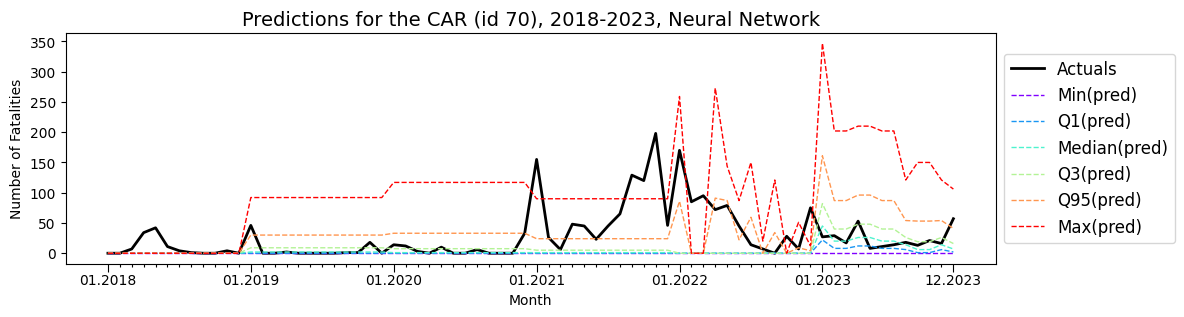

In [4]:
#------------------------------------
country_to_plot = 70 #133!! 57 124 133 126
method = 'NN'  # bmConflict  bmLastPois  NB  Hurdle NN
#------------------------------------
s_prediction_list = list(range(3, 15))

month_list_plot = []
actual_list = []
min_list = []
quant_025_list = []
quant_050_list = []
quant_075_list = []
quant_095_list = []
max_list = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    model_data = prediction_data_list[dataset_index][method]

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
        empirical_distribution = model_data.loc[(prediction_month,country_to_plot),:].values.flatten()

        month_list_plot.append(prediction_month)
        actual_list.append(actual_group.get_group(country_to_plot).iloc[s-3,0])
        min_list.append(min(empirical_distribution))
        quant_025_list.append(np.percentile(empirical_distribution, 25))
        quant_050_list.append(np.percentile(empirical_distribution, 50))
        quant_075_list.append(np.percentile(empirical_distribution, 75))
        quant_095_list.append(np.percentile(empirical_distribution, 95))
        max_list.append(max(empirical_distribution))


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Beispielwerte für Actuals und Quantile
months = month_list_plot
actuals = actual_list
minimum = min_list
quantile_25 = quant_025_list
quantile_50 = quant_050_list
quantile_75 = quant_075_list
quantile_95 = quant_095_list
maximum = max_list

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, actuals, color='black', linewidth=2, label='Actuals')
plt.plot(months, minimum, color=plt.cm.rainbow(0),linewidth=1, linestyle='--', label='Min(pred)')
plt.plot(months, quantile_25, color=plt.cm.rainbow(0.2),linewidth=1, linestyle='--', label='Q1(pred)')
plt.plot(months, quantile_50, color=plt.cm.rainbow(0.4),linewidth=1, linestyle='--', label='Median(pred)')
plt.plot(months, quantile_75, color=plt.cm.rainbow(0.6),linewidth=1, linestyle='--', label='Q3(pred)')
plt.plot(months, quantile_95, color=plt.cm.rainbow(0.8),linewidth=1, linestyle='--', label='Q95(pred)')
plt.plot(months, maximum, color=plt.cm.rainbow(1.0),linewidth=1, linestyle='--', label='Max(pred)')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','01.2022','01.2023','12.2023']
january_list = [0,12,24,36,48,60,71]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.xlabel('Month')
plt.ylabel('Number of Fatalities')
#plt.title('Predictions for Afghanistan (id 133), 2018-2021, Hurdle', fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
plt.title('Predictions for the CAR (id 70), 2018-2023, Neural Network', fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
#plt.title(str(country_to_plot), fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Zeige das Diagramm
plt.show()

# CRPS over all countries

In [5]:
s_prediction_list = list(range(3, 15))

month_list_plot = []
crps_last_poisson = []
crps_conflictology = []
crps_nb_baseline = []
crps_hurdle_baseline = []
crps_nn = []

for year in actual_years:    
    print(year)
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['bmLastPois']
    conflictology_data = prediction_data_list[dataset_index]['bmConflict']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_crps_last_poisson = []
        mean_crps_conflictology = []
        mean_crps_nb_baseline = []
        mean_crps_hurdle_baseline = []
        mean_crps_nn_empirical = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            conflictology_empirical_distribution = conflictology_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()

            mean_crps_last_poisson.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
            mean_crps_conflictology.append(pscore(conflictology_empirical_distribution,y_true).compute()[0])
            mean_crps_nb_baseline.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_hurdle_baseline.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_empirical.append(pscore(nn_empirical_distribution,y_true).compute()[0])

        month_list_plot.append(prediction_month)
        crps_last_poisson.append(np.mean(mean_crps_last_poisson))
        crps_conflictology.append(np.mean(mean_crps_conflictology))
        crps_nb_baseline.append(np.mean(mean_crps_nb_baseline))
        crps_hurdle_baseline.append(np.mean(mean_crps_hurdle_baseline))
        crps_nn.append(np.mean(mean_crps_nn_empirical))

2018


C:\Users\Tobias\AppData\Local\Temp\ipykernel_36276\160219867.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_36276\160219867.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_36276\160219867.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()


KeyError: 1

In [8]:
prediction_month

457

In [10]:
country

1

In [9]:
nn_data.loc[(prediction_month,country),:].values.flatten()

C:\Users\Tobias\AppData\Local\Temp\ipykernel_36276\3308150362.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_data.loc[(prediction_month,country),:].values.flatten()


KeyError: 1

In [11]:
hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()

C:\Users\Tobias\AppData\Local\Temp\ipykernel_36276\1940124237.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
len(prediction_data_list[0]['NN'].index.get_level_values('country_id').unique().tolist())

94

In [7]:
prediction_data_list[0]['Hurdle']

outcome
month_id country_id draw         
457      1          0           0
                    1           0
                    2           0
                    3           0
                    4           0
...                           ...
468      246        994       478
                    995       503
                    996       536
                    997       582
                    998       662

[2289708 rows x 1 columns]

In [ ]:
crps_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': [],
    '2022': [],
    '2023': []
}

Keys_crps_by_year = list(crps_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48], [48,60], [60,72]]

for i in range(len(crps_by_year)):
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_last_poisson[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflictology[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nb_baseline[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nn[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'Conflictology Benchmark',
    'NB Variant 3',
    'Hurdle Variant 1',
    'Neural Network'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(crps_by_year.keys(), [crps_by_year[jahr][i] for jahr in crps_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average CRPS from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average CRPS')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper left') #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
crps_by_year['2021']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


months = month_list_plot
last_poisson = crps_last_poisson
conflictology = crps_conflictology
nb_baseline = crps_nb_baseline
hurdle_baseline = crps_hurdle_baseline
nn = crps_nn

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, last_poisson, color='orange', linewidth=1, label='Last Poisson Benchmark')
plt.plot(months, last_poisson, color='blue', linewidth=1, label='Conflictology Benchmark')
plt.plot(months, nb_baseline, color='green', linewidth=1, label='NB Variant 3')
plt.plot(months, hurdle_baseline, color='red', linewidth=1, label='Hurdle Variant 1')
plt.plot(months, nn, linewidth=1, color='purple', label='Neural Network')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','01.2022','12.2023']
january_list = [0,12,24,36,48,60,71]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.title('Monthly Average CRPS from Different Models, 2018-2023', fontsize=13, y=1)
plt.xlabel('Month')
plt.ylabel('Average CRPS')

# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(fontsize=12, loc='upper left')

# Zeige das Diagramm
plt.show()

# CRPS over different levels of conflicts

In [ ]:
s_prediction_list = list(range(3, 15))

month_list_plot = []

crps_last_poisson_low = []
crps_conflictology_low = []
crps_nb_baseline_low = []
crps_hurdle_baseline_low = []
crps_nn_low = []

crps_last_poisson_middle = []
crps_conflictology_middle = []
crps_nb_baseline_middle = []
crps_hurdle_baseline_middle = []
crps_nn_middle = []

crps_last_poisson_high = []
crps_conflictology_high = []
crps_nb_baseline_high = []
crps_hurdle_baseline_high = []
crps_nn_high = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['bmLastPois']
    conflictology_data = prediction_data_list[dataset_index]['bmConflict']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_crps_last_poisson_low = []
        mean_crps_conflictology_low = []
        mean_crps_nb_baseline_low = []
        mean_crps_hurdle_baseline_low = []
        mean_crps_nn_empirical_low = []

        mean_crps_last_poisson_middle = []
        mean_crps_conflictology_middle = []
        mean_crps_nb_baseline_middle = []
        mean_crps_hurdle_baseline_middle = []
        mean_crps_nn_empirical_middle = []

        mean_crps_last_poisson_high = []
        mean_crps_conflictology_high = []
        mean_crps_nb_baseline_high = []
        mean_crps_hurdle_baseline_high = []
        mean_crps_nn_empirical_high = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            conflictology_empirical_distribution = conflictology_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()


            if country in countries_with_low_conflict_list:
                mean_crps_last_poisson_low.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_conflictology_low.append(pscore(conflictology_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_low.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_low.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_low.append(pscore(nn_empirical_distribution,y_true).compute()[0])

            elif country in countries_with_middle_conflict_list:
                mean_crps_last_poisson_middle.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_conflictology_middle.append(pscore(conflictology_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_middle.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_middle.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_middle.append(pscore(nn_empirical_distribution,y_true).compute()[0])

            elif country in countries_with_high_conflict_list:
                mean_crps_last_poisson_high.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_conflictology_high.append(pscore(conflictology_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_high.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_high.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_high.append(pscore(nn_empirical_distribution,y_true).compute()[0])

        month_list_plot.append(prediction_month)

        crps_last_poisson_low.append(np.mean(mean_crps_last_poisson_low))
        crps_conflictology_low.appen(np.mean(mean_crps_conflictology_low))
        crps_nb_baseline_low.append(np.mean(mean_crps_nb_baseline_low))
        crps_hurdle_baseline_low.append(np.mean(mean_crps_hurdle_baseline_low))
        crps_nn_low.append(np.mean(mean_crps_nn_empirical_low))

        crps_last_poisson_middle.append(np.mean(mean_crps_last_poisson_middle))
        crps_conflictology_middle.append(np.mean(mean_crps_conflictology_middle))
        crps_nb_baseline_middle.append(np.mean(mean_crps_nb_baseline_middle))
        crps_hurdle_baseline_middle.append(np.mean(mean_crps_hurdle_baseline_middle))
        crps_nn_middle.append(np.mean(mean_crps_nn_empirical_middle))

        crps_last_poisson_high.append(np.mean(mean_crps_last_poisson_high))
        crps_conflictology_high.append(np.mean(mean_crps_conflictology_high))
        crps_nb_baseline_high.append(np.mean(mean_crps_nb_baseline_high))
        crps_hurdle_baseline_high.append(np.mean(mean_crps_hurdle_baseline_high))
        crps_nn_high.append(np.mean(mean_crps_nn_empirical_high))

In [ ]:
len(countries_with_low_conflict_list) + len(countries_with_middle_conflict_list) + len(countries_with_high_conflict_list) + len(zero_fatalities_country_list)

In [ ]:
crps_conflict_level = {'low':{'pois':crps_last_poisson_low, 
                              'conflictology':crps_conflictology_low,
                              'NB':crps_nb_baseline_low, 
                              'Hurdle':crps_hurdle_baseline_low, 
                              'NN':crps_nn_low
                              },
                        'middle':{'pois':crps_last_poisson_middle, 
                                  'conflictology':crps_conflictology_middle,
                              'NB':crps_nb_baseline_middle, 
                              'Hurdle':crps_hurdle_baseline_middle, 
                              'NN':crps_nn_middle
                              },
                        'high':{'pois':crps_last_poisson_high, 
                                'conflictology':crps_conflictology_high,
                              'NB':crps_nb_baseline_high, 
                              'Hurdle':crps_hurdle_baseline_high, 
                              'NN':crps_nn_high
                              },
                              }

In [ ]:
conflict_level = 'high'

crps_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': [],
    '2022': [],
    '2023': []
}

Keys_crps_by_year = list(crps_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48], [48,60], [60,72]]

for i in range(len(crps_by_year)):
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['pois'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['conflictology'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NB'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['Hurdle'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NN'][index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'Conflictology Benchmark'
    'NB Variant 3',
    'Hurdle Variant 1',
    'Neural Network'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(crps_by_year.keys(), [crps_by_year[jahr][i] for jahr in crps_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average CRPS from Different Models, '  +'High' + ' Conflict Level', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average CRPS')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper left')#, bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

conflict_level = 'low'

months = month_list_plot

last_poisson = crps_conflict_level[conflict_level]['pois']
conflictology = crps_conflict_level[conflict_level]['conflictology']
nb_baseline = crps_conflict_level[conflict_level]['NB']
hurdle_baseline = crps_conflict_level[conflict_level]['Hurdle']
nn = crps_conflict_level[conflict_level]['NN']

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, last_poisson, color='orange', linewidth=1, label='Last Poisson Benchmark')
plt.plot(months, conflictology, color='blue', linewidth=1, label='Conflictology Benchmark')
plt.plot(months, nb_baseline, color='green', linewidth=1, label='NB Variant 3')
plt.plot(months, hurdle_baseline, linewidth=1, color='red', label='Hurdle Variant 1')
plt.plot(months, nn, linewidth=1, color='purple', label='Neural Network')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','01.2022','12.2023']
january_list = [0,12,24,36,48,60,71]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.title('Monthly Average CRPS from Different Models, 2018-2023, ' + 'Low' + ' Conflict Level', fontsize=14, y=1)
plt.xlabel('Month')
plt.ylabel('Average CRPS')

# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Zeige das Diagramm
plt.show()

# Geomap Performance of the different models throughout the test window years 

In [ ]:
import CRPS.CRPS as pscore
import warnings

warnings.filterwarnings("ignore")

s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'best_model': []}
df_best_model_dict = {'2018':pd.DataFrame(data),'2019':pd.DataFrame(data),'2020':pd.DataFrame(data),'2021':pd.DataFrame(data),
                      '2022':pd.DataFrame(data),'2023':pd.DataFrame(data)}
keys_list = list(df_best_model_dict.keys())

model_list = ['Poisson Benchm.', 'Conflictology Benchm.' 'NB', 'Hurdle', 'Neural Net']
iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']


for i in range(len(actual_years)): 
    year = actual_years[i]   
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['bmLastPois']
    conflictology_data = prediction_data_list[dataset_index]['bmConflict']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for country in country_list:
        
        mean_crps_last_poisson = []
        mean_crps_conflictology = []
        mean_crps_nb_baseline = []
        mean_crps_hurdle_baseline = []
        mean_crps_nn_empirical = []

        
        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            conflictology_empirical_distribution = conflictology_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()

            mean_crps_last_poisson.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
            mean_crps_conflictology.append(pscore(conflictology_empirical_distribution,y_true).compute()[0])
            mean_crps_nb_baseline.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_hurdle_baseline.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_empirical.append(pscore(nn_empirical_distribution,y_true).compute()[0])

        crps_poisson = np.mean(mean_crps_last_poisson)
        crps_conflictology = np.mean(mean_crps_conflictology)
        crps_nb = np.mean(mean_crps_nb_baseline)
        crps_hurdle = np.mean(mean_crps_hurdle_baseline)
        crps_nn = np.mean(mean_crps_nn_empirical)


        # Liste der Variablen
        variables = [crps_poisson, crps_conflictology, crps_nb, crps_hurdle, crps_nn]

        # Initialisieren der Variable mit dem minimalen Wert
        min_var = np.min(variables)

        model_string = ''

        if all(var == variables[0] for var in variables):
            model_string = 'No Preferred Model'
        else:
            # Schleife zur Überprüfung
            for j in range(len(variables)):
                var = variables[j]
                if var == min_var:
                    model_string = model_list[j]

        df_best_model_dict[keys_list[i]].loc[len(df_best_model_dict[keys_list[i]])] = [country, model_string]
    df_best_model_dict[keys_list[i]]['code'] = iso_2_codes_list

In [ ]:
import geopandas as gpd
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import country_converter as coco

relative_path_shapefile = os.path.join('..', 'plots_model_comp','ne_10m_admin_0_countries', 'ne_10m_admin_0_countries.shp')
SHAPEFILE = os.path.join(current_dir, relative_path_shapefile)


# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Next, we need to ensure that our data matches with the country codes. 
iso3_codes = geo_df['country'].to_list()
# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list
# There are some countries for which the converter could not find a country code. 
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)


In [ ]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_18 = pd.merge(left=geo_df, right=df_best_model_dict['2018'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_18.drop(['code'], axis=1)

colors = ['green','blue','red','lightgrey', 'orange', 'purple']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)

""" # Hier kommt die Anpassung der Legende
legend = ax.get_legend()
new_labels = ['Hurdle Variant 1', 'NB Variant 2', 'Neural Network', 'Neural Network NB', 'No Preferred Model', 'Last Poisson Benchmark']  # Ersetzen Sie diese mit Ihren eigenen Labels
for t, l in zip(legend.texts, new_labels):
    t.set_text(l) """

ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2018',fontsize=16)
plt.tight_layout()

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_19 = pd.merge(left=geo_df, right=df_best_model_dict['2019'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_19.drop(['code'], axis=1)

colors = ['green','blue','red','lightgrey', 'orange', 'purple']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2019',fontsize=16)
plt.tight_layout()

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_20 = pd.merge(left=geo_df, right=df_best_model_dict['2020'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_20.drop(['code'], axis=1)

colors = ['green','blue','red','lightgrey', 'orange', 'purple']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2020',fontsize=16)
plt.tight_layout()

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_21 = pd.merge(left=geo_df, right=df_best_model_dict['2021'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_21.drop(['code'], axis=1)

colors = ['green','blue','red','lightgrey', 'orange', 'purple']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2021',fontsize=16)
plt.tight_layout()

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_22 = pd.merge(left=geo_df, right=df_best_model_dict['2022'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_22.drop(['code'], axis=1)

colors = ['green','blue','red','lightgrey', 'orange', 'purple']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2022',fontsize=16)
plt.tight_layout()

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_23 = pd.merge(left=geo_df, right=df_best_model_dict['2023'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_23.drop(['code'], axis=1)

colors = ['green','blue','red','lightgrey', 'orange', 'purple']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2023',fontsize=16)
plt.tight_layout()

# Secondary metrics: Interval and ignorance score

In [ ]:
import numpy as np
from collections import Counter

bins = [
        0,
        0.5,
        2.5,
        5.5,
        10.5,
        25.5,
        50.5,
        100.5,
        250.5,
        500.5,
        1000.5,
    ]

def _ensemble_ignorance_score(predictions, n, observed):
        c = Counter(predictions)
        # n = c.total() : this works from python version 3.10, avoid this for a while.
        prob = c[observed] / n # if counter[observed] is 0, then this returns correctly
        return -np.log2(prob)

def ensemble_ignorance_score(observations, forecasts, bins, low_bin = 0, high_bin = 10000):
    """
    This implements the Ensemble (Ranked) interval Score from the easyVerification R-package in Python. Also inspired by properscoring.crps_ensemble(),
    and has interface that works with the xskillscore package.

    Parameters
    ----------
    observations : float or array_like
        Observations float or array. Missing values (NaN) are given scores of
        NaN.
    forecasts : float or array_like
        Array of forecasts ensemble members, of the same shape as observations
        except for the axis along which RIGN is calculated (which should be the
        axis corresponding to the ensemble). If forecasts has the same shape as
        observations, the forecasts are treated as deterministic. Missing
        values (NaN) are ignored.
    round_values: converts input data to integers by rounding.
    

    Returns
    -------
    out : np.ndarray
        RIGN for each ensemble forecast against the observations.
    """
    observations = np.asarray(observations)
    forecasts = np.asarray(forecasts)

    assert np.all(forecasts >= 0), f"Forecasts must be non-negative."
    assert np.all(observations >= 0), f"Observations must be non-negative."

    assert isinstance(bins, (int, list)), f"bins must be an integer or a list with floats"
    if isinstance(bins, int):
        assert bins > 0, f"bins must be an integer above 0 or a list with floats."

    def digitize_minus_one(x, bins, right=False):
        return np.digitize(x, bins, right) - 1

    """ edges = np.histogram_bin_edges(forecasts[..., :], bins = bins, range = (low_bin, high_bin))
    binned_forecasts =  np.apply_along_axis(digitize_minus_one, axis = 1, arr = forecasts, bins = edges)
    binned_observations = digitize_minus_one(observations, edges) """

    edges = np.histogram_bin_edges(forecasts, bins=bins, range=(low_bin, high_bin))
    binned_forecasts = digitize_minus_one(forecasts, edges)
    binned_observations = digitize_minus_one(observations, edges)


    # Append one observation in each bin-category to the forecasts to prevent 0 probability occuring.
    unique_categories = np.arange(0, len(bins))
    binned_forecasts = np.concatenate((binned_forecasts, np.tile(unique_categories, binned_forecasts.shape[:-1] + (1,))), axis = -1)
    
    n = binned_forecasts.shape[-1]

    #if observations.shape == forecasts.shape:
        # exact prediction yields 0 ign
    ign_score = np.empty_like(binned_observations, dtype = float)
    for index in np.ndindex(ign_score.shape):
        ign_score[index] = _ensemble_ignorance_score(binned_forecasts[index], n, binned_observations[index])
    
    
    return ign_score

def interval_score(observed: np.array, predictions: np.array, prediction_interval_level: float = 0.90) -> np.array:
    """
    Interval Score implemented based on the scaled Mean Interval Score in the R tsRNN package https://rdrr.io/github/thfuchs/tsRNN/src/R/metrics_dist.R

    The Interval Score is a probabilistic prediction evaluation metric that weights between the narrowness of the forecast range and the ability to correctly hit the observed value within that interval.
    
    :param observed: observed values
    :type observed: array_like
    :param predictions: probabilistic predictions with the latter axis (-1) being the forecasts for each observed value
    :type predictions: array_like
    :param prediction_interval_level: prediction interval between [0, 1]
    :type prediction_interval_level: float
    :returns array_like with the interval score for each observed value
    :rtype array_like

    observed = np.random.negative_binomial(5, 0.8, size = 600)
    forecasts = np.random.negative_binomial(5, 0.8, size = (600, 1000))

    score = interval_score(observed, forecasts)
    print(f'MIS: {score.mean()}')

    """

    assert 0 < prediction_interval_level < 1, f"'prediction_interval_level' must be a number between 0 and 1." 

    alpha = 1 - prediction_interval_level
    lower = np.quantile(predictions, q = alpha/2, axis = -1)
    upper = np.quantile(predictions, q = 1 - (alpha/2), axis = -1)

    interval_width = upper - lower
    lower_coverage = (2/alpha)*(lower-observed) * (observed<lower)
    upper_coverage = (2/alpha)*(observed-upper) * (observed>upper)

    return(interval_width + lower_coverage + upper_coverage)

# Mean interval score for all models and test windows

In [ ]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []
ignorance_last_poisson = []
ignorance_conflictology = []
ignorance_nb_baseline = []
ignorance_hurdle_baseline = []
ignorance_nn = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['bmLastPois']
    conflictology_data = prediction_data_list[dataset_index]['bmConflict']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_ignorance_last_poisson = []
        mean_ignorance_conflictology = []
        mean_ignorance_nb_baseline = []
        mean_ignorance_hurdle_baseline = []
        mean_ignorance_nn_empirical = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            conflictology_empirical_distribution = conflictology_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()

            mean_ignorance_last_poisson.append(ensemble_ignorance_score(y_true, last_poisson_empirical_distribution, bins) + 0)
            mean_ignorance_conflictology.append(ensemble_ignorance_score(y_true, conflictology_empirical_distribution, bins) + 0)
            mean_ignorance_nb_baseline.append(ensemble_ignorance_score(y_true, nb_baseline_empirical_distribution, bins) + 0)
            mean_ignorance_hurdle_baseline.append(ensemble_ignorance_score(y_true, hurdle_baseline_empirical_distribution, bins) + 0)
            mean_ignorance_nn_empirical.append(ensemble_ignorance_score(y_true, nn_empirical_distribution, bins) + 0)

        month_list_plot.append(prediction_month)
        ignorance_last_poisson.append(np.mean(mean_ignorance_last_poisson))
        ignorance_conflictology.append(np.mean(mean_ignorance_conflictology))
        ignorance_nb_baseline.append(np.mean(mean_ignorance_nb_baseline))
        ignorance_hurdle_baseline.append(np.mean(mean_ignorance_hurdle_baseline))
        ignorance_nn.append(np.mean(mean_ignorance_nn_empirical))

In [ ]:
ignorance_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': [],
    '2022': [],
    '2023': []
}

Keys_ignorance_by_year = list(ignorance_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48], [48,60], [60,72]]

for i in range(len(ignorance_by_year)):
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_last_poisson[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_conflictology[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nb_baseline[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nn[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'Conflictology Benchmark',
    'NB Variant 3',
    'Hurdle Variant 1',
    'Neural Network'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(ignorance_by_year.keys(), [ignorance_by_year[jahr][i] for jahr in ignorance_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average Ignorance Score from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Ignorance Score')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper right') #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
ignorance_by_year['2021']

# Mean interval score for all models and test windows

In [ ]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []
interval_last_poisson = []
interval_conflictology = []
interval_nb_baseline = []
interval_hurdle_baseline = []
interval_nn = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['bmLastPois']
    conflictology_data = prediction_data_list[dataset_index]['bmConflict']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_interval_last_poisson = []
        mean_interval_conflictology = []
        mean_interval_nb_baseline = []
        mean_interval_hurdle_baseline = []
        mean_interval_nn_empirical = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            conflictology_empirical_distribution = conflictology_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()

            mean_interval_last_poisson.append(interval_score(y_true, last_poisson_empirical_distribution))
            mean_interval_conflictology.append(interval_score(y_true, conflictology_empirical_distribution))
            mean_interval_nb_baseline.append(interval_score(y_true, nb_baseline_empirical_distribution))
            mean_interval_hurdle_baseline.append(interval_score(y_true, hurdle_baseline_empirical_distribution))
            mean_interval_nn_empirical.append(interval_score(y_true, nn_empirical_distribution))

        month_list_plot.append(prediction_month)
        interval_last_poisson.append(np.mean(mean_interval_last_poisson))
        interval_conflictology.append(np.mean(mean_interval_conflictology))
        interval_nb_baseline.append(np.mean(mean_interval_nb_baseline))
        interval_hurdle_baseline.append(np.mean(mean_interval_hurdle_baseline))
        interval_nn.append(np.mean(mean_interval_nn_empirical))

In [ ]:
interval_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': [],
    '2022': [],
    '2023': []
}

Keys_interval_by_year = list(interval_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48], [48,60], [60,72]]

for i in range(len(interval_by_year)):
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_last_poisson[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_conflictology[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_nb_baseline[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_nn[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'Conflictology Benchmark'
    'NB Variant 3',
    'Hurdle Variant 1',
    'Neural Network'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(interval_by_year.keys(), [interval_by_year[jahr][i] for jahr in interval_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average Interval Score from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Interval Score')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper left') #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
interval_by_year['2021']

# Geopandas map mean ignorance score NB Variant 3 2018-2021

In [ ]:
s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'average_ignorance': []}
df_nb_average_ignorance = pd.DataFrame(data)

iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']

for country in country_list:

    ignorance_nb_year = []

    for i in range(len(actual_years)): 
        
        year = actual_years[i]   
        dataset_index = actual_years.index(year)
        nb_baseline_data = prediction_data_list[dataset_index]['NB']

        actual_data = actuals_df_list[dataset_index]['data']
        actual_group = actual_data.groupby('country_id')

        mean_ignorance_nb = []

        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            # hier einfach anderes modell einsetzen falls mean berechnet werden soll

            mean_ignorance_nb.append(ensemble_ignorance_score(y_true, nb_baseline_empirical_distribution, bins) + 0)

        ignorance_nb_year.append(np.mean(mean_ignorance_nb))

    df_nb_average_ignorance.loc[len(df_nb_average_ignorance)] = [country, np.mean(ignorance_nb_year)]


df_nb_average_ignorance['code'] = iso_2_codes_list

In [ ]:
df_nb_average_ignorance

In [ ]:
np.mean(df_nb_average_ignorance['average_ignorance'])

# Geopandas map mean interval score NB Variant 3 2018-2021

In [ ]:
s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'average_interval': []}
df_nb_average_interval = pd.DataFrame(data)

iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']

for country in country_list:

    interval_nb_year = []

    for i in range(len(actual_years)): 
        
        year = actual_years[i]   
        dataset_index = actual_years.index(year)
        nb_baseline_data = prediction_data_list[dataset_index]['NB']

        actual_data = actuals_df_list[dataset_index]['data']
        actual_group = actual_data.groupby('country_id')

        mean_interval_nb = []

        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()

            mean_interval_nb.append(interval_score(y_true, nb_baseline_empirical_distribution))
            # hier einfach anderes modell einsetzen falls mean berechnet werden soll

        interval_nb_year.append(np.mean(mean_interval_nb))

    df_nb_average_interval.loc[len(df_nb_average_interval)] = [country, np.mean(interval_nb_year)]


df_nb_average_interval['code'] = iso_2_codes_list

In [ ]:
np.mean(df_nb_average_interval['average_interval'])